National Taiwan University  
YANG YU HSIANG

國立臺灣大學  
地理環境資源學系研究所 碩士班   
楊宇翔

# 計算距離
點與點間的計算以距離為基礎，它有許多應用，例如
1. 點圖層計算各點的距離矩陣，可輕易查得點與點間的距離  
2. 兩個點圖層之間的距離關係，例如，與最近的醫院的距離，醫院周圍十公里內的社區與人口數
3. 空間內插，由附近的點推算點的變數值。與距離的平方成反比，加總變數值
4. kennel density，另一種由附近的點推算點變數值的方法。假設附近點都是一個常態分佈，加總變數值。  
5. 資源可近性，計算資源多寡的各種方法。

Volcano-threaten_Cities  

有火山威脅的世界城市

# 安裝 geopandas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import warnings
warnings.filterwarnings('ignore')
! pip install geopandas

In [5]:
# 繪圖的補充包
! pip uninstall rtree
! sudo apt install libspatialindex-dev
! pip install rtree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 319 kB of archives.
After this operation, 1,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex6 amd64 1.9.3-2 [247 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-c6 amd64 1.9.3-2 [55.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-dev amd64 1.9.3-2 [16.0 kB]
Fetched 319 kB in 0s (944 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <

In [6]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rtree
from geopy import distance
from sklearn.linear_model import LinearRegression

# 與 google drive 連線

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 程式小百科：兩層迴圈，建構 dataframe
* 什麼時候會壞掉?
* 經常會出錯的地方
   * 語法錯誤，例如，沒對齊，少了':'，兩個等號==，指令拼錯，少了括弧，(){}[] 搞錯，全型與半型搞錯，執行時，會出現錯誤訊息。
   * 運算的錯誤，例如：不能除以0, 字串與數字相加，nan 做斷詞處理
   * 邏輯的錯誤，這比較不好找，當發現答案怪怪的，要回去查。技巧 print, stop



# 點與點間的距離

## 讀取點圖層

In [8]:
os.chdir("/content/drive/MyDrive/shape/")
cities = gpd.read_file("world_cities.shp")
cities

,no,city,country,iso3,population,geometry
0,1,Tokyo,Japan,JPN,37977000,POINT (139.69220 35.68970)
1,2,Jakarta,Indonesia,IDN,34540000,POINT (106.84510 -6.21460)
2,3,Delhi,India,IND,29617000,POINT (77.23000 28.66000)
3,4,Mumbai,India,IND,23355000,POINT (72.83330 18.96670)
4,5,Manila,Philippines,PHL,23088000,POINT (120.98330 14.60000)
...,...,...,...,...,...,...
4703,4704,Bacabal,Brazil,BRA,100014,POINT (-44.78000 -4.22500)
4704,4705,Delft,Netherlands,NLD,100011,POINT (4.35940 52.01190)
4705,4706,Zahle,Lebanon,LBN,100000,POINT (35.90720 33.84390)
4706,4707,Roubaix,France,FRA,100000,POINT (3.18170 50.69010)


In [9]:
cities = cities.drop_duplicates(subset=['city'])
len(cities)

4550

In [10]:
#########################
# 取前500個就好，以節省時間
cities=cities.iloc[:500]
cities.shape

(500, 6)

In [11]:
# 以城市名稱排序
cities=cities.sort_values(by=["city"])
cities.index=range(len(cities))

In [12]:
cities

,no,city,country,iso3,population,geometry
0,150,Abidjan,CeDoire,CIV,4980000,POINT (-4.02670 5.33640)
1,345,Accra,Ghana,GHA,2291352,POINT (-0.18700 5.60370)
2,350,Adana,Turkey,TUR,2220125,POINT (35.32500 37.00000)
3,257,Addis Ababa,Ethiopia,ETH,3041002,POINT (38.73690 9.02720)
4,471,Agra,India,IND,1585705,POINT (78.02000 27.18000)
...,...,...,...,...,...,...
495,64,Zhumadian,China,CHN,7640000,POINT (114.02530 32.97730)
496,202,Zhuzhou,China,CHN,4028500,POINT (113.14690 27.84070)
497,172,Zibo,China,CHN,4530597,POINT (118.04970 36.78310)
498,289,Zigong,China,CHN,2800000,POINT (104.76450 29.34980)


## 查點座標

In [13]:
# 查點座標資訊，請注意格式
cities.loc[cities.city=='Taipei'].geometry

412    POINT (121.53190 25.04780)
Name: geometry, dtype: geometry

In [14]:
# 讀取點的經緯度座標，轉為 tuple of float 型式
name='Taipei'
x=float(cities[cities.city==name].geometry.x)
y=float(cities[cities.city==name].geometry.y)
Taipei_coo=(x,y)
print (Taipei_coo)

(121.5319, 25.0478)


In [15]:
# 從編碼查詢
number=412
x=cities.iloc[number].geometry.x
y=cities.iloc[number].geometry.y
coo=(x,y)
print (coo)

(121.5319, 25.0478)


## 計算兩地理單元的距離公里數

In [16]:
# 由城市查座標, 注意先緯度再經度，這主要是要配合distance 函數的設定
def coor(city):
    x=float(cities[cities["city"]==city].geometry.x)
    y=float(cities[cities["city"]==city].geometry.y)
    return (y,x)

In [17]:
point1=coor('Taipei')
point2=coor('Tokyo')

In [18]:
# 注意先緯度再經度
point1

(25.0478, 121.5319)

In [19]:
point2

(35.6897, 139.6922)

## distance.distance()

In [20]:
# 注意座標的定義，先緯度再經度
d = distance.distance(point1,point2)
d.km

2101.1708637810293

## distance.great_circle()

In [21]:
# 大圓距離
d = distance.great_circle(point1,point2)
d.km

2100.3395581697882

# 距離矩陣
* 多個點之間的距離計算

## 單一點圖層的距離距陣

In [22]:
# 城市名稱
cityname=cities.city
# 空白的 datafreame, index, columns 先做好
df_dis=pd.DataFrame(columns=cities.city, index=cities.city)
# 逐一填資料進去
for n in range(len(cities)):
    # 標的的座標 tuple
    target =(cities.geometry[n].y,cities.geometry[n].x)
    # 與另一個城市的距離
    for m in range(n, len(cities)):
        if n==m:
            df_dis.iloc[n,m]=0
        else:
            # 另一個城市的座標
            point =(cities.geometry[m].y,cities.geometry[m].x)
            # 距離計算
            d = distance.great_circle(point,target)
            # 公里數
            df_dis.iloc[n,m]=d.km
            df_dis.iloc[m,n]=d.km
    print (n, end=',')
df_dis

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

city,Abidjan,Accra,Adana,Addis Ababa,Agra,Ahmedabad,Aleppo,Alexandria,Algiers,Almaty,...,Zhenjiang,Zhongli,Zhongshan,Zhoukou,Zhuhai,Zhumadian,Zhuzhou,Zibo,Zigong,Zunyi
city,,,,,,,,,,,,,,,,,,,,,
Abidjan,0,426.048386,5322.576768,4732.947981,8951.278094,8406.722148,5417.921624,4559.053883,3569.663466,8866.866687,...,12735.161543,13208.970586,12540.9815,12260.082103,12570.53582,12232.497102,12344.524992,12407.074652,11512.145699,11763.231435
Accra,426.048386,0,5016.052249,4307.691042,8558.147266,8002.512951,5101.266502,4235.454625,3481.956529,8536.199816,...,12383.947005,12831.735066,12147.931533,11908.095451,12176.89623,11877.07986,11968.568348,12073.64661,11134.400518,11381.515941
Adana,5322.576768,5016.052249,0,3129.374299,4130.853684,3877.408682,185.615328,814.466342,2855.783448,3564.60803,...,7455.852555,8027.093266,7498.779673,6987.074799,7532.936462,6970.527131,7175.486626,7095.278231,6377.4567,6650.482334
Addis Ababa,4732.947981,4307.691042,3129.374299,0,4588.160112,3923.561886,3025.743178,2629.018445,4732.963798,5303.256067,...,8604.748361,8832.465261,8051.845784,8151.943283,8075.58096,8094.367688,8013.016368,8459.254096,7199.211055,7401.66651
Agra,8951.278094,8558.147266,4130.853684,4588.160112,0,716.048026,3963.819836,4654.82268,6974.036736,1789.75188,...,4016.623177,4300.420777,3590.054308,3565.395381,3619.36492,3506.507458,3453.11537,3892.810308,2624.675121,2847.296021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zhumadian,12232.497102,11877.07986,6970.527131,8094.367688,3506.507458,4187.691238,6852.790614,7691.219501,9462.556301,3410.259562,...,515.704798,1132.033537,1163.2114,92.030952,1190.680712,0,577.334632,560.098085,968.574317,897.794352
Zhuzhou,12344.524992,11968.568348,7175.486626,8013.016368,3453.11537,4090.354566,7044.605795,7857.633939,9776.030091,3660.763967,...,777.504519,864.746536,590.510109,658.837406,620.116322,577.334632,0,1095.461803,835.207332,611.42023
Zibo,12407.074652,12073.64661,7095.278231,8459.254096,3892.810308,4593.413982,6991.856247,7848.034986,9449.592525,3540.223569,...,524.44553,1348.177036,1647.652505,468.103418,1669.688085,560.098085,1095.461803,0,1486.223204,1451.172158


In [23]:
df_dis.shape

(500, 500)

## 查詢兩點之間的距離

In [24]:
# 因為有設 index 直接打城市名即可
df_dis['Taipei'].loc['Tokyo']

2100.3395581697882

## 存檔

In [26]:
pth="/content/drive/MyDrive/"
# save, 存檔時 index 會跑掉
filename='data/cities_dis_matrtix.xlsx'
df_dis.to_excel(pth+filename)

In [27]:
# 直接讀檔，以節省時間 ######################################
filename='data/cities_dis_matrtix.xlsx'
df_dis=pd.read_excel(pth+filename)
# set_index
df_dis=df_dis.set_index('city')
df_dis

,Abidjan,Accra,Adana,Addis Ababa,Agra,Ahmedabad,Aleppo,Alexandria,Algiers,Almaty,...,Zhenjiang,Zhongli,Zhongshan,Zhoukou,Zhuhai,Zhumadian,Zhuzhou,Zibo,Zigong,Zunyi
city,,,,,,,,,,,,,,,,,,,,,
Abidjan,0.000000,426.048386,5322.576768,4732.947981,8951.278094,8406.722148,5417.921624,4559.053883,3569.663466,8866.866687,...,12735.161543,13208.970586,12540.981500,12260.082103,12570.535820,12232.497102,12344.524992,12407.074652,11512.145699,11763.231435
Accra,426.048386,0.000000,5016.052249,4307.691042,8558.147266,8002.512951,5101.266502,4235.454625,3481.956529,8536.199816,...,12383.947005,12831.735066,12147.931533,11908.095451,12176.896230,11877.079860,11968.568348,12073.646610,11134.400518,11381.515941
Adana,5322.576768,5016.052249,0.000000,3129.374299,4130.853684,3877.408682,185.615328,814.466342,2855.783448,3564.608030,...,7455.852555,8027.093266,7498.779673,6987.074799,7532.936462,6970.527131,7175.486626,7095.278231,6377.456700,6650.482334
Addis Ababa,4732.947981,4307.691042,3129.374299,0.000000,4588.160112,3923.561886,3025.743178,2629.018445,4732.963798,5303.256067,...,8604.748361,8832.465261,8051.845784,8151.943283,8075.580960,8094.367688,8013.016368,8459.254096,7199.211055,7401.666510
Agra,8951.278094,8558.147266,4130.853684,4588.160112,0.000000,716.048026,3963.819836,4654.822680,6974.036736,1789.751880,...,4016.623177,4300.420777,3590.054308,3565.395381,3619.364920,3506.507458,3453.115370,3892.810308,2624.675121,2847.296021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zhumadian,12232.497102,11877.079860,6970.527131,8094.367688,3506.507458,4187.691238,6852.790614,7691.219501,9462.556301,3410.259562,...,515.704798,1132.033537,1163.211400,92.030952,1190.680712,0.000000,577.334632,560.098085,968.574317,897.794352
Zhuzhou,12344.524992,11968.568348,7175.486626,8013.016368,3453.115370,4090.354566,7044.605795,7857.633939,9776.030091,3660.763967,...,777.504519,864.746536,590.510109,658.837406,620.116322,577.334632,0.000000,1095.461803,835.207332,611.420230
Zibo,12407.074652,12073.646610,7095.278231,8459.254096,3892.810308,4593.413982,6991.856247,7848.034986,9449.592525,3540.223569,...,524.445530,1348.177036,1647.652505,468.103418,1669.688085,560.098085,1095.461803,0.000000,1486.223204,1451.172158


## 最接近的十個城市

In [28]:
# 從 1 起算，因為自己不算
n=10
# Taipei 那一欄，依距離排序，取十個
df_min=df_dis.sort_values(by=['Taipei'],ascending=True).iloc[1:n+1]
# 印出台北那一欄
df_min[['Taipei']]

,Taipei
city,
Zhongli,33.061019
Taichung,132.731930
Fuzhou,252.167451
Putian,257.319608
Tainan,267.316358
Ningde,270.297452
Quanzhou,297.312387
Kaohsiung,297.947802
Qingyang,298.856898


In [29]:
# 最接近的 N 個
near=10
# 城市名
city=df_dis.columns
# 空白的list
closest_city=[]
closest_dis=[]
# 每個城市逐一計算
for c in range(len(city)):
    # 依距離排序，小者在前
    df_min=df_dis.sort_values(by=[city[c]],ascending=True, axis=0).iloc[1:near+1]
    # 取最前面的 N 個距離
    closest_dis.append(list(df_min[city[c]]))
    # 取最前面的 N 個城市，注意我們有 index
    closest_city.append(list(df_min.index))
# 轉成dataframe
df_city_near=pd.DataFrame(closest_city,index=df_dis.index)
df_dis_near=pd.DataFrame(closest_dis,index=df_dis.index)

In [30]:
# 每個城市最接近號的 10 個城市
df_city_near

,0,1,2,3,4,5,6,7,8,9
city,,,,,,,,,,
Abidjan,Kumasi,Accra,Ouagadougou,Lagos,Ibadan,Bamako,Conakry,Onitsha,Douala,Kano
Accra,Kumasi,Lagos,Abidjan,Ibadan,Ouagadougou,Onitsha,Douala,Bamako,Kano,Yaounde
Adana,Mersin,Gaziantep,Aleppo,Konya,Sanliurfa,Ankara,Damascus,Antalya,Diyarbakir,Dayr az Zawr
Addis Ababa,Sanaa,Khartoum,Meru,Omdurman,Mogadishu,Nairobi,Kampala,Mecca,Jeddah,Dar es Salaam
Agra,Ghaziabad,Delhi,Jaipur,Cawnpore,Lucknow,Bhopal,Ludhiana,Mirzapur,Indore,Lahore
...,...,...,...,...,...,...,...,...,...,...
Zhumadian,Luohe,Zhoukou,Xinyang,Pingdingshan,Jiangguanchi,Nanyang,Fuyang,Bozhou,Zhengzhou,Xiangyang
Zhuzhou,Xiangtan,Changsha,Pingxiang,Loudi,Yiyang,Hengyang,Yichun,Shaoyang,Changde,Ji'an
Zibo,Binzhou,Shengli,Weifang,Jinan,Tai'an,Dezhou,Liaocheng,Linyi,Rizhao,Cangzhou


In [31]:
# 每個城市最接近號的 10 個城市距離
df_dis_near

,0,1,2,3,4,5,6,7,8,9
city,,,,,,,,,,
Abidjan,305.701328,426.048386,827.217705,830.709452,907.158195,921.953583,1164.149003,1199.497408,1527.877338,1564.523276
Accra,198.479476,407.658051,426.048386,495.246660,765.400026,773.507290,1108.982639,1160.363681,1191.436232,1311.497006
Adana,66.793496,182.852659,185.615328,268.831518,308.023279,390.574161,397.534011,411.445483,445.165746,471.037996
Addis Ababa,920.026952,994.615534,1005.449693,1005.790699,1066.443743,1166.376288,1184.606997,1383.218258,1392.454551,1760.948195
Agra,175.617865,181.953224,215.245107,242.439559,292.306808,441.188391,465.180429,507.938541,542.056558,602.402165
...,...,...,...,...,...,...,...,...,...,...
Zhumadian,67.364163,92.030952,94.697359,107.877299,117.976659,139.558452,166.266201,189.828610,199.884482,202.711712
Zhuzhou,22.035821,43.395126,72.939357,113.654195,114.776478,118.688554,121.626620,178.009698,195.538636,197.856698
Zibo,66.520963,82.862460,93.867454,95.919230,108.179418,171.172241,188.105037,193.339401,196.318973,199.661350


In [32]:
## 看看台北
df_city_near.loc['Taipei']

0      Zhongli
1     Taichung
2       Fuzhou
3       Putian
4       Tainan
5       Ningde
6     Quanzhou
7    Kaohsiung
8     Qingyang
9     Ximeicun
Name: Taipei, dtype: object

In [33]:
# 距離
df_dis_near.loc['Taipei']

0     33.061019
1    132.731930
2    252.167451
3    257.319608
4    267.316358
5    270.297452
6    297.312387
7    297.947802
8    298.856898
9    317.645533
Name: Taipei, dtype: float64

# 點與標的

## 讀取火山資料檔

In [34]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/data/vocano.csv', encoding = 'utf-8')
df.head()

,Name,Country,Type,Latitude,Longitude,Elevation (m)
0,Abu,Japan,Shield,34.50,131.60,641
1,Acamarachi,Chile,Stratovolcano,-23.30,-67.62,6046
2,Acatenango,Guatemala,Stratovolcano,14.50,-90.88,3976
3,Acig?l-Nevsehir,Turkey,Caldera,38.57,34.52,1689
4,Adams,United States,Stratovolcano,46.21,-121.49,3742


In [35]:
len(df)

195

## 轉換為 geopandas
* 讀取經緯度資訊，成為 geopandas
* 存成 shape files

In [36]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
# 從 df 讀取經緯度資訊，這裡是先經度再緯度
geometry = [Point(xy) for xy in zip( df.Longitude,df.Latitude)]
# 刪除多餘的欄位
df_vocano = df.drop(['Longitude', 'Latitude'], axis=1)
# 定義投影
crs = {'init': 'epsg:4326'}
# 製作 geopandas
vocano = GeoDataFrame(df_vocano, crs=crs, geometry=geometry)

In [37]:
# geopandas 格式，注意新增一個 geometry 欄位
vocano

,Name,Country,Type,Elevation (m),geometry
0,Abu,Japan,Shield,641,POINT (131.60000 34.50000)
1,Acamarachi,Chile,Stratovolcano,6046,POINT (-67.62000 -23.30000)
2,Acatenango,Guatemala,Stratovolcano,3976,POINT (-90.88000 14.50000)
3,Acig?l-Nevsehir,Turkey,Caldera,1689,POINT (34.52000 38.57000)
4,Adams,United States,Stratovolcano,3742,POINT (-121.49000 46.21000)
...,...,...,...,...,...
190,Koryaksky,Russia,Stratovolcano,3456,POINT (158.69000 53.32000)
191,Koshelev,Russia,Stratovolcano,1812,POINT (156.75000 51.36000)
192,Krafla,Iceland,Caldera,818,POINT (-16.78000 65.73000)
193,Krakatau,Indonesia,Stratovolcano,813,POINT (105.42000 -6.10000)


<Axes: >

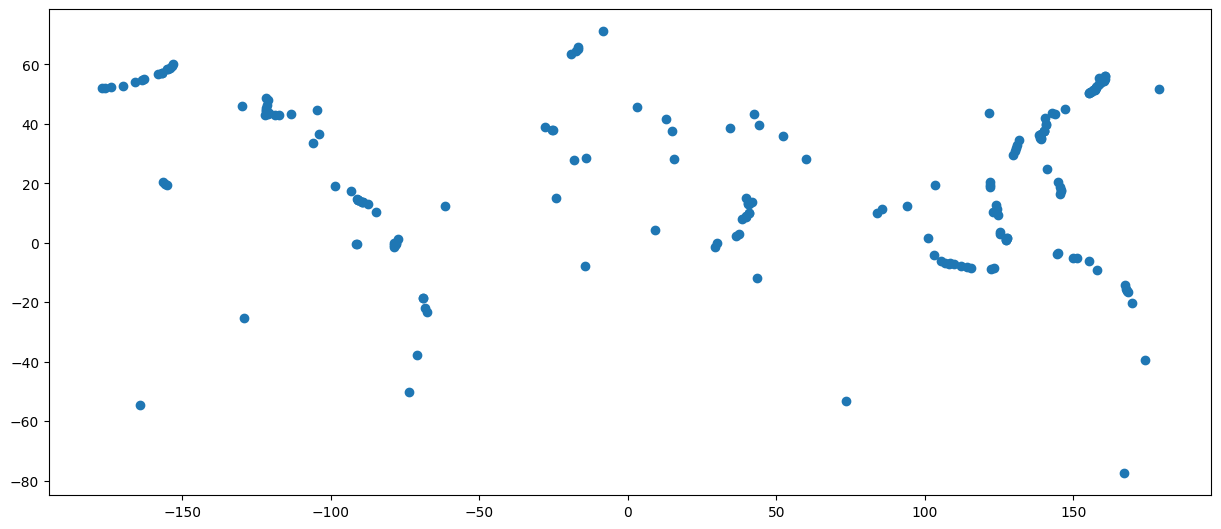

In [38]:
vocano.plot(figsize=(15, 10))

In [39]:
vocano.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## 套疊地圖

In [40]:
path="/content/drive/MyDrive/"
# 讀取 shape 檔，國家
world = gpd.read_file(path+"shape/countries.shp")
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [41]:
# 城市的投影
cities.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

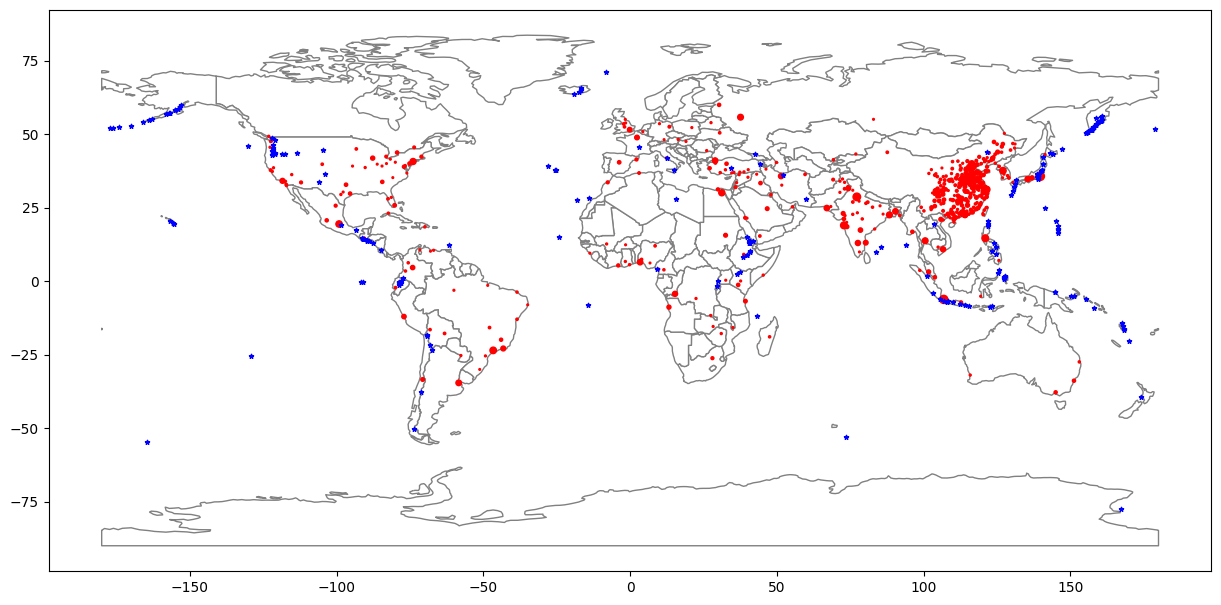

In [42]:
## 投影一致可以套疊地圖
# 底圖是國家
base = world.plot(color='white', edgecolor='gray',figsize=(15, 10))
# 上面是城市，人口數決定大小
cities.plot(ax=base,figsize=(15, 10),marker='o', color = 'red', markersize=cities['population']/1000000)
# 上面是 火山
vocano.plot(ax=base,marker='*', color = 'blue', markersize=10,figsize=(15, 10))

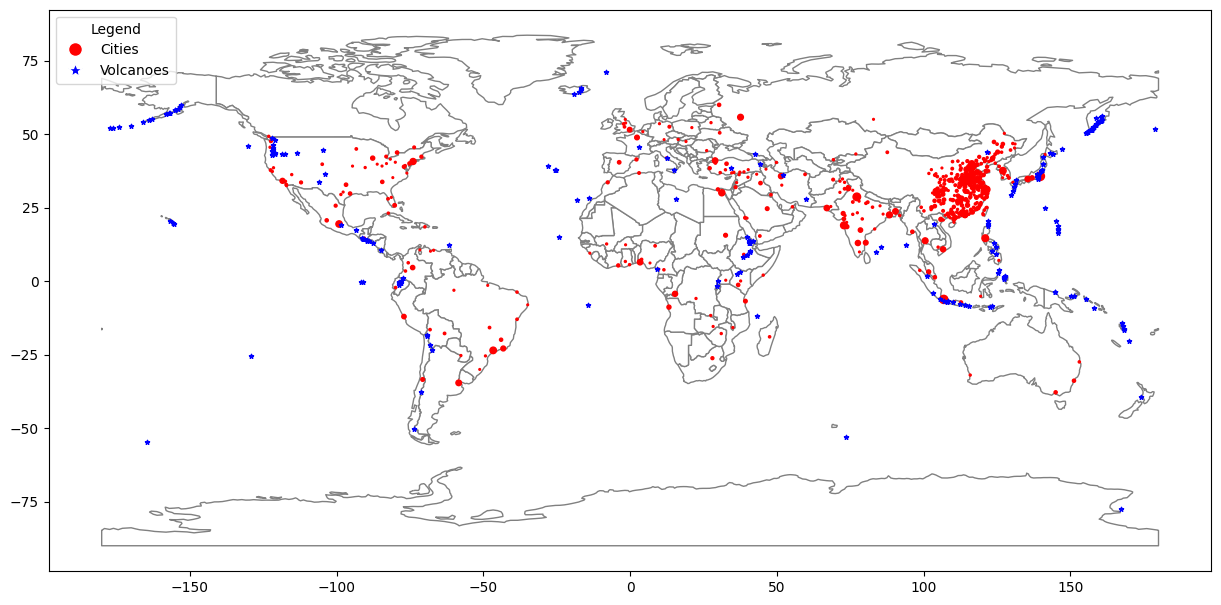

In [66]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming 'world', 'cities', and 'vocano' are already defined GeoDataFrames

# Plot the base map (countries)
base = world.plot(color='white', edgecolor='gray', figsize=(15, 10))

# Plot the cities, size determined by population
cities_plot = cities.plot(ax=base, marker='o', color='red', markersize=cities['population']/1000000, label='Cities')

# Plot the volcanoes
vocano_plot = vocano.plot(ax=base, marker='*', color='blue', markersize=10, label='Volcanoes')

# Create custom legend elements
city_marker = plt.Line2D([0], [0], marker='o', color='w', label='Cities', markerfacecolor='red', markersize=10)
volcano_marker = plt.Line2D([0], [0], marker='*', color='w', label='Volcanoes', markerfacecolor='blue', markersize=10)

# Adding custom legend elements to the plot
plt.legend(handles=[city_marker, volcano_marker], title='Legend', loc='upper left')

# Show the plot
plt.show()

## 存檔

In [43]:
pth="/content/drive/MyDrive/"
# save shape
vocano.to_file(pth+"shape/vocano.shp")

<Axes: >

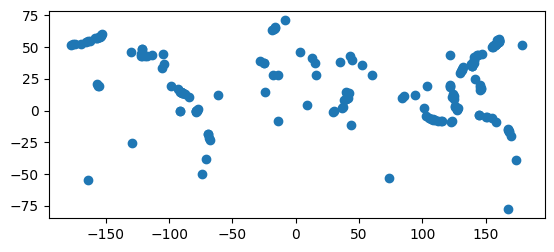

In [44]:
# 直接讀檔 ##############################################
# 讀取 shape 檔
vocano = gpd.read_file(pth+"shape/vocano.shp")
vocano.plot()

## 火山與城市的距離矩陣

In [45]:
cities

,no,city,country,iso3,population,geometry
0,150,Abidjan,CeDoire,CIV,4980000,POINT (-4.02670 5.33640)
1,345,Accra,Ghana,GHA,2291352,POINT (-0.18700 5.60370)
2,350,Adana,Turkey,TUR,2220125,POINT (35.32500 37.00000)
3,257,Addis Ababa,Ethiopia,ETH,3041002,POINT (38.73690 9.02720)
4,471,Agra,India,IND,1585705,POINT (78.02000 27.18000)
...,...,...,...,...,...,...
495,64,Zhumadian,China,CHN,7640000,POINT (114.02530 32.97730)
496,202,Zhuzhou,China,CHN,4028500,POINT (113.14690 27.84070)
497,172,Zibo,China,CHN,4530597,POINT (118.04970 36.78310)
498,289,Zigong,China,CHN,2800000,POINT (104.76450 29.34980)


In [46]:
city

Index(['Abidjan', 'Accra', 'Adana', 'Addis Ababa', 'Agra', 'Ahmedabad',
       'Aleppo', 'Alexandria', 'Algiers', 'Almaty',
       ...
       'Zhenjiang', 'Zhongli', 'Zhongshan', 'Zhoukou', 'Zhuhai', 'Zhumadian',
       'Zhuzhou', 'Zibo', 'Zigong', 'Zunyi'],
      dtype='object', length=500)

In [47]:
vocano

,Name,Country,Type,Elevation,geometry
0,Abu,Japan,Shield,641,POINT (131.60000 34.50000)
1,Acamarachi,Chile,Stratovolcano,6046,POINT (-67.62000 -23.30000)
2,Acatenango,Guatemala,Stratovolcano,3976,POINT (-90.88000 14.50000)
3,Acig?l-Nevsehir,Turkey,Caldera,1689,POINT (34.52000 38.57000)
4,Adams,United States,Stratovolcano,3742,POINT (-121.49000 46.21000)
...,...,...,...,...,...
190,Koryaksky,Russia,Stratovolcano,3456,POINT (158.69000 53.32000)
191,Koshelev,Russia,Stratovolcano,1812,POINT (156.75000 51.36000)
192,Krafla,Iceland,Caldera,818,POINT (-16.78000 65.73000)
193,Krakatau,Indonesia,Stratovolcano,813,POINT (105.42000 -6.10000)


### 開始計算距離矩陣

In [48]:
# 火山名稱
location=vocano.Name
city=cities.city
# 空白的 datafreame, index, columns 先做好
df_dis2=pd.DataFrame(columns=location, index=city)
# 逐一填資料進去
for n in range(len(city)):
    # 以城市為標的，計算與每個火山的距離
    target =(cities.geometry[n].y,cities.geometry[n].x)
    # 與火山的距離
    for m in range(len(location)):
        # 火山的座標
        point =(vocano.geometry[m].y,vocano.geometry[m].x)
        # 距離計算
        d = distance.great_circle(point,target)
        # 公里數
        df_dis2.iloc[n,m]=d.km
    print (n, end=',')
df_dis2

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

Name,Abu,Acamarachi,Acatenango,Acig?l-Nevsehir,Adams,Adams Seamount,Adatara,Adwa,Afder?,Agrigan,...,Kilimanjaro,Kirishima,Kliuchevskoi,Komagatake,Kone,Koryaksky,Koshelev,Krafla,Krakatau,Krasheninnikov
city,,,,,,,,,,,,,,,,,,,,,
Abidjan,13595.399591,7593.488336,9521.615591,5357.167728,11621.493869,13786.610984,13977.756819,4967.980689,4993.040884,15748.186445,...,4594.555951,13696.061083,13045.402006,13649.816609,4836.840924,13294.335377,13449.93707,6789.214818,12214.332669,13194.179628
Accra,13279.116114,7984.993999,9926.036532,5062.628995,11864.37388,14177.370004,13704.595031,4543.505362,4572.637541,15395.74455,...,4170.713038,13365.589687,12937.342004,13400.455348,4411.415977,13169.919954,13310.364877,6810.218034,11793.140494,13080.515803
Adana,8272.829031,12645.760314,11989.046817,188.362698,10476.863968,18065.536228,8697.247844,3045.287867,2716.014144,10449.107089,...,3778.52988,8378.551635,8453.473316,8423.044985,3166.427063,8592.569492,8659.210395,4602.100747,8682.970746,8558.838151
Addis Ababa,9700.253711,12066.055328,13874.781225,3311.923693,13565.536303,17799.137985,10395.194611,258.121332,506.203026,11432.908928,...,679.915828,9676.551703,11039.3258,10304.729948,107.704876,11087.646596,11077.096673,7573.210136,7578.979469,11104.963846
Agra,5120.960639,16543.107301,15228.171923,4212.052089,11620.74005,17292.008428,5854.031068,4330.866899,4164.717288,6910.016742,...,5083.379959,5088.634149,7085.349148,5833.13366,4512.312625,7016.053775,6923.817153,7484.028594,4730.599031,7092.145794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zhumadian,1631.808249,18927.07399,14110.136112,6970.679584,9598.000644,13901.489275,2430.502614,7837.237177,7663.408732,3518.709746,...,8579.932414,1582.184855,4375.462558,2544.956719,8018.81468,4174.270668,3992.783535,8260.025125,4439.257572,4309.862885
Zhuzhou,1901.630043,19504.390574,14642.230297,7193.308358,10116.002628,13871.999294,2749.746731,7754.901515,7609.329858,3459.033604,...,8452.550062,1764.858408,4877.084919,2945.597566,7930.577222,4657.49659,4462.028896,8773.644239,3864.190309,4801.018738
Zibo,1249.370462,18420.50382,13556.74981,7077.305922,9040.004006,13608.53757,1967.222635,8204.313623,8010.495975,3354.377439,...,8975.296057,1292.366623,3815.364501,2023.598691,8389.171025,3615.535295,3436.723497,7974.132915,4946.146624,3750.207072


## 與火山最接近的十個城市及其距離

In [49]:
# 最接近的 n 個
near=10
# 火山名稱
location=df_dis2.columns
# 空白的 list
closest_city=[]
closest_dis=[]
# 每個火山依序計算
for c in range(len(location)):
    # 距離由小到大排序，取前十個
    df_min=df_dis2.sort_values(by=[location[c]],ascending=True, axis=0).iloc[:near]
    # 前十個城市名稱
    closest_city.append(list(df_min.index))
    # 最近的十個距離
    closest_dis.append(list(df_min[location[c]]))
# 存成 dataframe
df_city_near=pd.DataFrame(closest_city, index=location)
df_dis_near=pd.DataFrame(closest_dis, index=location)

In [50]:
df_dis_near

,0,1,2,3,4,5,6,7,8,9
Name,,,,,,,,,,
Abu,147.984341,243.047807,312.113693,328.636114,354.273693,384.864182,433.785445,433.786725,491.664847,536.181162
Acamarachi,758.775382,766.349700,1035.939720,1167.139246,1543.128488,1598.464858,1789.945943,1872.013125,2139.485255,2227.288875
Acatenango,40.093611,926.411444,1034.743985,1038.379000,1313.175318,1488.385329,1582.723048,1675.991444,1735.022363,1761.507889
Acig?l-Nevsehir,188.362698,194.023424,196.999126,208.673075,301.968403,351.310819,383.673031,406.466076,501.772474,504.533219
Adams,116.882035,169.220500,358.817649,849.899242,943.295104,990.980407,1224.471434,1370.012621,1407.838154,1525.598533
...,...,...,...,...,...,...,...,...,...,...
Koryaksky,1710.091513,2088.460818,2130.648510,2155.598878,2181.285804,2314.420885,2363.288702,2437.003203,2456.123592,2483.304065
Koshelev,1479.411321,1928.517944,1975.182156,2009.593809,2046.361260,2141.886671,2208.400882,2217.647288,2235.313820,2284.614349
Krafla,1445.311372,1567.828458,1580.141155,1690.877085,1839.239021,1996.550458,2044.217507,2180.312475,2224.552420,2411.639012


In [51]:
df_city_near

,0,1,2,3,4,5,6,7,8,9
Name,,,,,,,,,,
Abu,Fukuoka,Busan,Daegu,Kobe,Osaka,Kyoto,Gwangju,Daejeon,Nagoya,Seoul
Acamarachi,La Paz,Santa Cruz,Asuncion,Santiago,Buenos Aires,Lima,Porto Alegre,Curitiba,Sao Paulo,Brasilia
Acatenango,Guatemala City,Puebla,Mexico City,Ecatepec,Havana,Guadalajara,Monterrey,Miami,Tampa,Houston
Acig?l-Nevsehir,Adana,Konya,Mersin,Ankara,Gaziantep,Aleppo,Antalya,Sanliurfa,Bursa,Diyarbakir
Adams,Portland,Seattle,Vancouver,Sacramento,San Francisco,San Jose,Las Vegas,Los Angeles,Riverside,Denver
...,...,...,...,...,...,...,...,...,...,...
Koryaksky,Sapporo,Shuangyashan,Jiamusi,Heihe,Jixi,Mudanjiang,Suihua,Harbin,Tokyo,Yokohama
Koshelev,Sapporo,Shuangyashan,Jiamusi,Jixi,Heihe,Mudanjiang,Tokyo,Suihua,Yokohama,Harbin
Krafla,Newcastle,Leeds,Manchester,Birmingham,London,Hamburg,Brussels,Paris,Berlin,Saint Petersburg


## 火山最接近的十個城市的人口數

In [52]:
cities

,no,city,country,iso3,population,geometry
0,150,Abidjan,CeDoire,CIV,4980000,POINT (-4.02670 5.33640)
1,345,Accra,Ghana,GHA,2291352,POINT (-0.18700 5.60370)
2,350,Adana,Turkey,TUR,2220125,POINT (35.32500 37.00000)
3,257,Addis Ababa,Ethiopia,ETH,3041002,POINT (38.73690 9.02720)
4,471,Agra,India,IND,1585705,POINT (78.02000 27.18000)
...,...,...,...,...,...,...
495,64,Zhumadian,China,CHN,7640000,POINT (114.02530 32.97730)
496,202,Zhuzhou,China,CHN,4028500,POINT (113.14690 27.84070)
497,172,Zibo,China,CHN,4530597,POINT (118.04970 36.78310)
498,289,Zigong,China,CHN,2800000,POINT (104.76450 29.34980)


In [53]:
cities_id=cities.set_index('city')
cities_id

,no,country,iso3,population,geometry
city,,,,,
Abidjan,150,CeDoire,CIV,4980000,POINT (-4.02670 5.33640)
Accra,345,Ghana,GHA,2291352,POINT (-0.18700 5.60370)
Adana,350,Turkey,TUR,2220125,POINT (35.32500 37.00000)
Addis Ababa,257,Ethiopia,ETH,3041002,POINT (38.73690 9.02720)
Agra,471,India,IND,1585705,POINT (78.02000 27.18000)
...,...,...,...,...,...
Zhumadian,64,China,CHN,7640000,POINT (114.02530 32.97730)
Zhuzhou,202,China,CHN,4028500,POINT (113.14690 27.84070)
Zibo,172,China,CHN,4530597,POINT (118.04970 36.78310)


In [54]:
# 火山最接近的十個城市的人口數
location=df_city_near.index
popu=[]
for n in range(len(location)):
    # 所有鄰近城市的距離，取前十個
    near=df_city_near.loc[location[n]][:10]
    # 加總其人口數
    sum= cities_id.loc[near].population.sum()
    # 加入 list
    popu.append(sum)
# 製作 dataframe
df_city_near['popu_sum']=popu
df_city_near

,0,1,2,3,4,5,6,7,8,9,popu_sum
Name,,,,,,,,,,,
Abu,Fukuoka,Busan,Daegu,Kobe,Osaka,Kyoto,Gwangju,Daejeon,Nagoya,Seoul,60209706
Acamarachi,La Paz,Santa Cruz,Asuncion,Santiago,Buenos Aires,Lima,Porto Alegre,Curitiba,Sao Paulo,Brasilia,69326744
Acatenango,Guatemala City,Puebla,Mexico City,Ecatepec,Havana,Guadalajara,Monterrey,Miami,Tampa,Houston,53186089
Acig?l-Nevsehir,Adana,Konya,Mersin,Ankara,Gaziantep,Aleppo,Antalya,Sanliurfa,Bursa,Diyarbakir,24762197
Adams,Portland,Seattle,Vancouver,Sacramento,San Francisco,San Jose,Las Vegas,Los Angeles,Riverside,Denver,35256711
...,...,...,...,...,...,...,...,...,...,...,...
Koryaksky,Sapporo,Shuangyashan,Jiamusi,Heihe,Jixi,Mudanjiang,Suihua,Harbin,Tokyo,Yokohama,63954320
Koshelev,Sapporo,Shuangyashan,Jiamusi,Jixi,Heihe,Mudanjiang,Tokyo,Suihua,Yokohama,Harbin,63954320
Krafla,Newcastle,Leeds,Manchester,Birmingham,London,Hamburg,Brussels,Paris,Berlin,Saint Petersburg,43734177


## 火山最接近的十個城市的平均人口數

In [55]:
location=df_city_near.index
popu_mean=[]
for n in range(len(location)):
    # 所有鄰近城市的距離，取前十個
    near=df_city_near.loc[location[n]][:10]
    # 人口平均值
    mean= cities_id.loc[near].population.mean()
    # 加入 list
    popu_mean.append(mean)
# 製作 dataframe
df_city_near['popu_mean']=popu_mean
df_city_near

,0,1,2,3,4,5,6,7,8,9,popu_sum,popu_mean
Name,,,,,,,,,,,,
Abu,Fukuoka,Busan,Daegu,Kobe,Osaka,Kyoto,Gwangju,Daejeon,Nagoya,Seoul,60209706,6020970.6
Acamarachi,La Paz,Santa Cruz,Asuncion,Santiago,Buenos Aires,Lima,Porto Alegre,Curitiba,Sao Paulo,Brasilia,69326744,6932674.4
Acatenango,Guatemala City,Puebla,Mexico City,Ecatepec,Havana,Guadalajara,Monterrey,Miami,Tampa,Houston,53186089,5318608.9
Acig?l-Nevsehir,Adana,Konya,Mersin,Ankara,Gaziantep,Aleppo,Antalya,Sanliurfa,Bursa,Diyarbakir,24762197,2476219.7
Adams,Portland,Seattle,Vancouver,Sacramento,San Francisco,San Jose,Las Vegas,Los Angeles,Riverside,Denver,35256711,3525671.1
...,...,...,...,...,...,...,...,...,...,...,...,...
Koryaksky,Sapporo,Shuangyashan,Jiamusi,Heihe,Jixi,Mudanjiang,Suihua,Harbin,Tokyo,Yokohama,63954320,6395432.0
Koshelev,Sapporo,Shuangyashan,Jiamusi,Jixi,Heihe,Mudanjiang,Tokyo,Suihua,Yokohama,Harbin,63954320,6395432.0
Krafla,Newcastle,Leeds,Manchester,Birmingham,London,Hamburg,Brussels,Paris,Berlin,Saint Petersburg,43734177,4373417.7


## 距離平方反比加權


In [56]:
dis=200
location=df_city_near.index
popu_dis_idw=[]
for n in range(len(location)):
    # 所有鄰近城市的距離，取前十個
    near=df_city_near.loc[location[n]][:10]
    # 前十個城市名
    near_city=list(df_city_near.loc[location[n]])[:10]
    # 計算idw
    # 前十個人口數 list，
    population= list(cities_id.loc[near_city].population)
    # 前十個距離 list，
    distance= list(cities_id.loc[near_city].population)
    total=0
    wei=0
    for n in range(len(population)):
        # 人口數加權
        weighted=population[n]*(1/distance[n]**2)
        # 加權總和，分子
        total+=weighted
        # 權數緦和，分母
        wei+=1/distance[n]**2
    # 加權平均
    idw=total/wei
    # 加入 list
    popu_dis_idw.append(idw)
df_city_near['popu_dis_idw']=popu_dis_idw
df_city_near


,0,1,2,3,4,5,6,7,8,9,popu_sum,popu_mean,popu_dis_idw
Name,,,,,,,,,,,,,
Abu,Fukuoka,Busan,Daegu,Kobe,Osaka,Kyoto,Gwangju,Daejeon,Nagoya,Seoul,60209706,6020970.6,1.845087e+06
Acamarachi,La Paz,Santa Cruz,Asuncion,Santiago,Buenos Aires,Lima,Porto Alegre,Curitiba,Sao Paulo,Brasilia,69326744,6932674.4,2.220329e+06
Acatenango,Guatemala City,Puebla,Mexico City,Ecatepec,Havana,Guadalajara,Monterrey,Miami,Tampa,Houston,53186089,5318608.9,2.299772e+06
Acig?l-Nevsehir,Adana,Konya,Mersin,Ankara,Gaziantep,Aleppo,Antalya,Sanliurfa,Bursa,Diyarbakir,24762197,2476219.7,2.103998e+06
Adams,Portland,Seattle,Vancouver,Sacramento,San Francisco,San Jose,Las Vegas,Los Angeles,Riverside,Denver,35256711,3525671.1,2.256507e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Koryaksky,Sapporo,Shuangyashan,Jiamusi,Heihe,Jixi,Mudanjiang,Suihua,Harbin,Tokyo,Yokohama,63954320,6395432.0,2.143720e+06
Koshelev,Sapporo,Shuangyashan,Jiamusi,Jixi,Heihe,Mudanjiang,Tokyo,Suihua,Yokohama,Harbin,63954320,6395432.0,2.143720e+06
Krafla,Newcastle,Leeds,Manchester,Birmingham,London,Hamburg,Brussels,Paris,Berlin,Saint Petersburg,43734177,4373417.7,2.185247e+06


## 火山周圍200km範圍內的人口數

In [57]:
dis=200
location=df_city_near.index
popu_dis_sum=[]
for n in range(len(location)):
    near=list(df_dis_near.loc[location[n]])
    num=len([x for x in near if x<= 200])
    near_city=list(df_city_near.loc[location[n]])[:num]
    sum= cities_id.loc[near_city].population.sum()
    popu_dis_sum.append(sum)
df_city_near['popu_dis_sum']=popu_dis_sum
df_city_near

,0,1,2,3,4,5,6,7,8,9,popu_sum,popu_mean,popu_dis_idw,popu_dis_sum
Name,,,,,,,,,,,,,,
Abu,Fukuoka,Busan,Daegu,Kobe,Osaka,Kyoto,Gwangju,Daejeon,Nagoya,Seoul,60209706,6020970.6,1.845087e+06,2128000
Acamarachi,La Paz,Santa Cruz,Asuncion,Santiago,Buenos Aires,Lima,Porto Alegre,Curitiba,Sao Paulo,Brasilia,69326744,6932674.4,2.220329e+06,0
Acatenango,Guatemala City,Puebla,Mexico City,Ecatepec,Havana,Guadalajara,Monterrey,Miami,Tampa,Houston,53186089,5318608.9,2.299772e+06,2450212
Acig?l-Nevsehir,Adana,Konya,Mersin,Ankara,Gaziantep,Aleppo,Antalya,Sanliurfa,Bursa,Diyarbakir,24762197,2476219.7,2.103998e+06,6266967
Adams,Portland,Seattle,Vancouver,Sacramento,San Francisco,San Jose,Las Vegas,Los Angeles,Riverside,Denver,35256711,3525671.1,2.256507e+06,5863990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Koryaksky,Sapporo,Shuangyashan,Jiamusi,Heihe,Jixi,Mudanjiang,Suihua,Harbin,Tokyo,Yokohama,63954320,6395432.0,2.143720e+06,0
Koshelev,Sapporo,Shuangyashan,Jiamusi,Jixi,Heihe,Mudanjiang,Tokyo,Suihua,Yokohama,Harbin,63954320,6395432.0,2.143720e+06,0
Krafla,Newcastle,Leeds,Manchester,Birmingham,London,Hamburg,Brussels,Paris,Berlin,Saint Petersburg,43734177,4373417.7,2.185247e+06,0


## 火山周圍200km範圍內的人口數平均

In [58]:
dis=200
location=df_city_near.index
popu_dis_mean=[]
for n in range(len(location)):
    # 所有鄰近城市的距離
    near=list(df_dis_near.loc[location[n]])
    # 小於門檻的個數
    num=len([x for x in near if x<= dis])
    # 取小於門鑑者
    near_city=list(df_city_near.loc[location[n]])[:num]
    # 計算平均
    mean= cities_id.loc[near_city].population.mean()
    # 加入 popu_dis_mean
    popu_dis_mean.append(mean)
# 製作 dataframe
df_city_near['popu_dis_mean']=popu_dis_mean
# 若無城市在200km 內，計算 mean() 會變成 nan 取代為 0
df_city_near['popu_dis_mean'] = df_city_near['popu_dis_mean'].fillna(0)
df_city_near


,0,1,2,3,4,5,6,7,8,9,popu_sum,popu_mean,popu_dis_idw,popu_dis_sum,popu_dis_mean
Name,,,,,,,,,,,,,,,
Abu,Fukuoka,Busan,Daegu,Kobe,Osaka,Kyoto,Gwangju,Daejeon,Nagoya,Seoul,60209706,6020970.6,1.845087e+06,2128000,2128000.0
Acamarachi,La Paz,Santa Cruz,Asuncion,Santiago,Buenos Aires,Lima,Porto Alegre,Curitiba,Sao Paulo,Brasilia,69326744,6932674.4,2.220329e+06,0,0.0
Acatenango,Guatemala City,Puebla,Mexico City,Ecatepec,Havana,Guadalajara,Monterrey,Miami,Tampa,Houston,53186089,5318608.9,2.299772e+06,2450212,2450212.0
Acig?l-Nevsehir,Adana,Konya,Mersin,Ankara,Gaziantep,Aleppo,Antalya,Sanliurfa,Bursa,Diyarbakir,24762197,2476219.7,2.103998e+06,6266967,2088989.0
Adams,Portland,Seattle,Vancouver,Sacramento,San Francisco,San Jose,Las Vegas,Los Angeles,Riverside,Denver,35256711,3525671.1,2.256507e+06,5863990,2931995.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Koryaksky,Sapporo,Shuangyashan,Jiamusi,Heihe,Jixi,Mudanjiang,Suihua,Harbin,Tokyo,Yokohama,63954320,6395432.0,2.143720e+06,0,0.0
Koshelev,Sapporo,Shuangyashan,Jiamusi,Jixi,Heihe,Mudanjiang,Tokyo,Suihua,Yokohama,Harbin,63954320,6395432.0,2.143720e+06,0,0.0
Krafla,Newcastle,Leeds,Manchester,Birmingham,London,Hamburg,Brussels,Paris,Berlin,Saint Petersburg,43734177,4373417.7,2.185247e+06,0,0.0


## 火山與最近的城市距離

In [59]:
df_nearest=pd.DataFrame()
df_nearest['nearest city']=df_city_near[0]
df_nearest['nearest dis']=df_dis_near[0]
df_nearest

,nearest city,nearest dis
Name,,
Abu,Fukuoka,147.984341
Acamarachi,La Paz,758.775382
Acatenango,Guatemala City,40.093611
Acig?l-Nevsehir,Adana,188.362698
Adams,Portland,116.882035
...,...,...
Koryaksky,Sapporo,1710.091513
Koshelev,Sapporo,1479.411321
Krafla,Newcastle,1445.311372


## 城市 200km 內是否有火山?

In [60]:
cities

,no,city,country,iso3,population,geometry
0,150,Abidjan,CeDoire,CIV,4980000,POINT (-4.02670 5.33640)
1,345,Accra,Ghana,GHA,2291352,POINT (-0.18700 5.60370)
2,350,Adana,Turkey,TUR,2220125,POINT (35.32500 37.00000)
3,257,Addis Ababa,Ethiopia,ETH,3041002,POINT (38.73690 9.02720)
4,471,Agra,India,IND,1585705,POINT (78.02000 27.18000)
...,...,...,...,...,...,...
495,64,Zhumadian,China,CHN,7640000,POINT (114.02530 32.97730)
496,202,Zhuzhou,China,CHN,4028500,POINT (113.14690 27.84070)
497,172,Zibo,China,CHN,4530597,POINT (118.04970 36.78310)
498,289,Zigong,China,CHN,2800000,POINT (104.76450 29.34980)


In [61]:
# 最接近的 n 個
near=10
# 火山名稱
lovation=df_dis2.columns
city=cities.city
# 空白的 list
closest_vocano=[]
closest_dis=[]
# 每個城市依序計算
for c in range(len(city)):
    # 距離由小到大排序，取前十個
    df_min=df_dis2.sort_values(by=[city[c]],ascending=True, axis=1).loc[city[c]][:near]
    # 前十個火山名稱
    closest_vocano.append(list(df_min.index))
    # 最近的十個距離
    closest_dis.append(list(df_min))
# 存成 dataframe
df_vocano_near=pd.DataFrame(closest_vocano, index=city)
df_dis_vocano=pd.DataFrame(closest_dis, index=city)

In [62]:
df_vocano_near

,0,1,2,3,4,5,6,7,8,9
city,,,,,,,,,,
Abidjan,Cameroon (Mount),Ascensi?n,Fogo,Fuerteventura,Hierro,Gran Canaria,Karisimbi,Katwe-Kikorongo,Etna,Furnas
Accra,Cameroon (Mount),Ascensi?n,Fogo,Fuerteventura,Gran Canaria,Hierro,Karisimbi,Katwe-Kikorongo,Etna,Barrier
Adana,Acig?l-Nevsehir,Ararat,Elbrus,Damavand,Etna,Alban Hills,Gran Canaria,Alid,Bazman,Erta Ale
Addis Ababa,Kone,Butajira,Fantale,Ayelu,Adwa,Alayta,Afder?,Ale Bagu,Erta Ale,Dubbi
Agra,Bazman,Concepci?n,Irazu,Barren Island,Damavand,Colima,Ararat,Elbrus,Kerinci,Dubbi
...,...,...,...,...,...,...,...,...,...,...
Zhumadian,Bachelor,Akuseki-jima,Kikai,Kirishima,Aso,Iraya,Abu,Babuyon Claro,Camiguin de Babuyanes,Colima
Zhuzhou,Iraya,Babuyon Claro,Camiguin de Babuyanes,Colima,Akuseki-jima,Kikai,Kirishima,Aso,Abu,Bachelor
Zibo,Bachelor,Abu,Aso,Kirishima,Kikai,Akuseki-jima,Asama,Iraya,Fuji,Akagi


In [63]:
df_dis_vocano

,0,1,2,3,4,5,6,7,8,9
city,,,,,,,,,,
Abidjan,1467.732323,1870.511134,2465.131918,2768.656672,2896.829578,3261.388598,3795.211035,3817.008964,4085.230530,4201.448403
Accra,1048.297144,2178.501099,2837.037577,2920.521778,2995.219495,3099.377600,3384.924746,3401.608820,3889.202142,4092.831818
Adana,188.362698,837.773628,927.694721,1503.388856,1794.555741,2008.302112,2098.755986,2501.275346,2511.501955,2656.186519
Addis Ababa,107.704876,116.691688,131.137208,245.029886,258.121332,472.829328,506.203026,540.528482,551.663538,608.294373
Agra,1776.611329,1914.915179,2007.887187,2339.492621,2631.221856,2742.984061,3398.454985,3656.282322,3762.941493,4046.830714
...,...,...,...,...,...,...,...,...,...,...
Zhumadian,1371.167552,1530.159450,1555.056437,1582.184855,1592.819073,1599.518308,1631.808249,1690.434192,1755.479403,1819.410163
Zhuzhou,1215.849873,1285.424328,1338.168811,1340.292160,1614.199419,1694.235503,1764.858408,1809.491299,1901.630043,1928.741580
Zibo,836.113293,1249.370462,1267.273578,1292.366623,1312.868416,1347.341430,1825.465792,1854.142141,1861.770943,1882.629988


The End